# А/B тестирование: интернет-магазин

<font color="DarkCyan">Что тут есть: приоритизация гипотез ICE/RICE, расчет кумулятивных показателей, подготовка выборок для теста, проверка критерием Манна-Уитни, анализ кумулятивной выручки/среднего чека/относительного среднего чека в сравнении выборок "А" и "Б"

Отдел маркетинга собрал список гипотез для увеличения выручки: приоритизируем их, запустим А/Б тест и интерпретируем результаты.

## Предобработка данных

> ○ подгрузим нужные нам библиотеки
<br> ○ объявим переменные с датасетами
<br> ○ напишем функцию и прогоним ей инфо о датасетах

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import datetime as dt

In [2]:
hyps = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
def lookatdf(hyps, orders, visitors):
    for df in [hyps, orders, visitors]:
        display(df.head(1))
        df.info()
    
lookatdf(hyps, orders, visitors)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,date,group,visitors
0,2019-08-01,A,719


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


> ○ поменяем формат данных в полях с датами
<br> ○ проверим все сеты на полные дубликаты строк

In [4]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
hyps.duplicated().sum() + orders.duplicated().sum() + visitors.duplicated().sum()

0

> ○ проверим сет заказов на предмет того, есть ли в разных группах юзеры с одинаковыми ID
<br> ○ удалим юзеров, которые одновременно присутствуют в обеих группах

In [5]:
suspects = orders.groupby('visitorId').agg({'group': 'nunique'}).rename(columns={'group': 'qt_groups'})
suspects = suspects.query('qt_groups > 1')
suspects.index.nunique()

58

> ○ видим, что есть пользователи, попавшие как в группу А, так и в группу Б
<br> ○ удалим юзеров, которые одновременно присутствуют в обеих группах, перезаписав сет orders

In [6]:
orders = orders.query('visitorId not in @suspects.index')

> **Данные обработали. Перейдем к приоритизации и работе с сетом hyps (гипотезы)**

## Приоритизация гипотез

### Приоритизация гипотез по ICE

> ○ создадим доп.поле в сете с гипотезами, рассчитав рейтинг по фреймворку ICE
<br> ○ посмотрим топ-5 гипотез в рамках фреймворка 

In [7]:
pd.options.display.max_colwidth = 400

hyps['ICE'] = (hyps['Impact'] * hyps['Confidence'])/hyps['Efforts']
display(hyps.sort_values(by='ICE', ascending=False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


> ○ "победила" гипотеза о запуске акции со скидкой на товар - видим почти максимальные цифры в факторах влияния / уверенности в оценке **(Impact / Confidence = 9)**, а также среднюю величину трудозатрат **(Efforts = 5)**
<br> ○ вместе с тем фактор охвата имеет очень низкий балл **(Reach = 1)**. Охватим мало пользователей, если приоритизируем по Ice - посмотрим, как изменится топ-5 в случае применения другого фреймворка  

### Приоритизация гипотез по RICE

> ○ применим фреймворк RICE, рассчитав оценку в отдельном поле датасета

In [8]:
hyps['RICE'] = (hyps['Reach'] * hyps['Impact'] * hyps['Confidence'])/hyps['Efforts']
hyps.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


> ○ в абсолютный топ вышла гипотеза с добавлением формы подписки на основные страницы магазина
<br> ○ фактор охвата самый высокий **(Reach = 10)**, включение этого фактора в оценку и изменило приоритизацию. Отметим, что данная - единственная с максимальным охватом, равным 10
<br> ○ также обратим внимание, что влияние / уверенность в оценке +- схожи с гипотезой, вышедшей в топ по модели ICE **(Impact = 7 / Confidence = 8)**, а трудозатраты вообще аналогичны **(Efforts = 5)**
<br> 
<br>**Итого рекомендовано остановиться на фреймворке RICE и выбрать для проведения гипотезу с добавлением формы подписки. В других сферах можно было бы остановиться и на ICE, но в случае интернет-магазина точно не стоит упускать из внимания параметр охвата**

## Анализ A/B-теста

### Подготовка датасета для анализа

> ○ соберем группировкой отдельные датафреймы по сету visitors: кол-во посетителей магазина по дням / кумулятивно в рамках каждой группы
<br> ○ аналогично поступим с датасетом orders, собрав дневные / кумулятивные данные по кол-ву заказов и выручке
<br> ○ добавим в кумулятивные фреймы orders доп.столбец с рассчитанным средним кумулятивным чеком. Округлим его до 2 знаков после запятой
<br> ○ объединим по дате все данные из полученных датафреймов, собрав общий сет. Дадим сету новое, короткое имя
<br> ○ добавим еще 2 поля с рассчитанным кумулятивным средним кол-вом заказов на посетителя. Округлим до 2 знаков после запятой
<br>
<br> **Сет будем собирать функцией - добавим в параметры фильтрацию (по умолчанию False), а также значение revenue_max. В дальнейшем нам понадобится быстро выкинуть выбросы из расчетов - предусмотрим этот момент заранее**

#### function: get_the_union 

In [9]:
def get_the_union(visitors, orders, revenue_max, filter_me=False):
    
    # фильтр по умолчанию неактивен, в случае активации отсекает заказы-"выбросы" (скалькулируем дальше, пока оставим без внимания)
    if filter_me:
        orders = orders.query('revenue <= @revenue_max')
    
    # A group, кол-во юзеров (кумулятивно на каждую дату)
    vis_a_daily = (visitors.query('group == "A"')[['date', 'visitors']]
                   .rename(columns={'visitors': 'vis_a_qt'})
                   .sort_values(by='date'))
    # A group, кол-во юзеров (кумулятивно на каждую дату
    vis_a_cummy = (vis_a_daily
                   .apply(lambda x: vis_a_daily[vis_a_daily['date'] <= x['date']]
                   .agg({'date': 'max', 'vis_a_qt': "sum"}), axis=1)
                   .rename(columns={'vis_a_qt': 'vis_a_qt_cummy'}))
    
    # B group, кол-во юзеров (дневное)
    vis_b_daily = (visitors.query('group == "B"')[['date', 'visitors']]
                   .rename(columns={'visitors': 'vis_b_qt'})
                   .sort_values(by='date'))

    # B group, кол-во юзеров (накопительно на каждую дату)
    vis_b_cummy = (vis_b_daily
                   .apply(lambda x: vis_b_daily[vis_b_daily['date'] <= x['date']]
                   .agg({'date': 'max', 'vis_b_qt': "sum"}), axis=1)
                   .rename(columns={'vis_b_qt': 'vis_b_qt_cummy'}))
    
    # A group, кол-во заказов / объем выручки (дневное)
    ord_a_daily = (orders.query('group == "A"')[['date', 'transactionId', 'visitorId', 'revenue']]
                   .groupby('date', as_index=False)
                   .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
                   .rename(columns={'transactionId': 'ord_a_qt', 'revenue': 'rev_a_daily'})
                   .sort_values(by='date'))
    # A group, кол-во заказов / объем выручки (накопительно на каждую дату)
    ord_a_cummy = (ord_a_daily
                   .apply(lambda x: ord_a_daily[ord_a_daily['date'] <= x['date']]
                   .agg({'date': 'max', 'ord_a_qt': 'sum', 'rev_a_daily': 'sum'}), axis=1)
                   .rename(columns={'ord_a_qt': 'ord_a_qt_cummy', 'rev_a_daily': 'rev_a_cummy'})
                   .sort_values(by='date'))
    
    # B group, кол-во заказов / объем выручки (дневное)
    ord_b_daily = (orders.query('group == "B"')[['date', 'transactionId', 'visitorId', 'revenue']]
                   .groupby('date', as_index=False)
                   .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
                   .rename(columns={'transactionId': 'ord_b_qt', 'revenue': 'rev_b_daily'})
                   .sort_values(by='date'))

    # B group, кол-во заказов / объем выручки (накопительно на каждую дату)
    ord_b_cummy = (ord_b_daily
                   .apply(lambda x: ord_b_daily[ord_b_daily['date'] <= x['date']]
                   .agg({'date': 'max', 'ord_b_qt': 'sum', 'rev_b_daily': 'sum'}), axis=1)
                   .rename(columns={'ord_b_qt': 'ord_b_qt_cummy', 'rev_b_daily': 'rev_b_cummy'})
                   .sort_values(by='date'))

    # A group, добавление поля с рассчитанным кумулятивным чеком
    ord_a_cummy['avg_check_a'] = round(ord_a_cummy['rev_a_cummy'] / ord_a_cummy['ord_a_qt_cummy'],2)

    # B group, добавление поля с рассчитанным кумулятивным чеком
    ord_b_cummy['avg_check_b'] = round(ord_b_cummy['rev_b_cummy'] / ord_b_cummy['ord_b_qt_cummy'],2)

    # собираем единый датасет, в строке будут все вышеперечисленные данные в рамках 1 даты (как дневные, так и кумулятивные)
    union_date = (ord_a_daily
             .merge(ord_b_daily, left_on='date', right_on='date', how='left')
             .merge(ord_a_cummy, left_on='date', right_on='date', how='left')
             .merge(ord_b_cummy, left_on='date', right_on='date', how='left')
             .merge(vis_a_daily, left_on='date', right_on='date', how='left')
             .merge(vis_b_daily, left_on='date', right_on='date', how='left')
             .merge(vis_a_cummy, left_on='date', right_on='date', how='left')
             .merge(vis_b_cummy, left_on='date', right_on='date', how='left'))

    # объявим новую короткую переменную для лаконичности кода
    ud = union_date

    # A group, среднее кол-во заказов на посетителя (накопительно на дату)
    ud['ord_by_vis_a'] = round(ud['vis_a_qt_cummy'] / ud['ord_a_qt_cummy'],2)

    # B group, среднее кол-во заказов на посетителя (накопительно на дату)
    ud['ord_by_vis_b'] = round(ud['vis_b_qt_cummy'] / ud['ord_b_qt_cummy'],2)
    
    return ud

> ○ объявим 2 переменные, рассчитав функцию - без фильтра данных и с фильтром (прим.: revenue_max калькулируется позднее в шаге расчета 99-го перцентиля стоимости заказа)
<br> ○ посмотрим на верхушку полученного датасета без фильтра данных

In [10]:
# задали параметр revenue_max
revenue_max = 53904

# рассчитали функцией итоговый датасет без фильтра данных
ud = get_the_union(visitors, orders, revenue_max)

# тот же датасет с фильтром данных (ud_f - сокращение от union_date_filtered)
ud_f = get_the_union(visitors, orders, revenue_max, filter_me=True)

ud.head(2)

,date,ord_a_qt,rev_a_daily,ord_b_qt,rev_b_daily,ord_a_qt_cummy,rev_a_cummy,avg_check_a,ord_b_qt_cummy,rev_b_cummy,avg_check_b,vis_a_qt,vis_b_qt,vis_a_qt_cummy,vis_b_qt_cummy,ord_by_vis_a,ord_by_vis_b
0,2019-08-01,23,142779,17,59758,23,142779,6207.78,17,59758,3515.18,719,713,719,713,31.26,41.94
1,2019-08-02,19,91602,23,162043,42,234381,5580.50,40,221801,5545.02,619,581,1338,1294,31.86,32.35


> **Посмотрели верхушку полученного датасета - видим, что дневные/ кумулятивные данные указаны верно, средний чек / среднее кол-во заказов посчитано правильно. Можем переходить к построению графиков по сету**

### Анализ показателя: кумулятивная выручка по группам

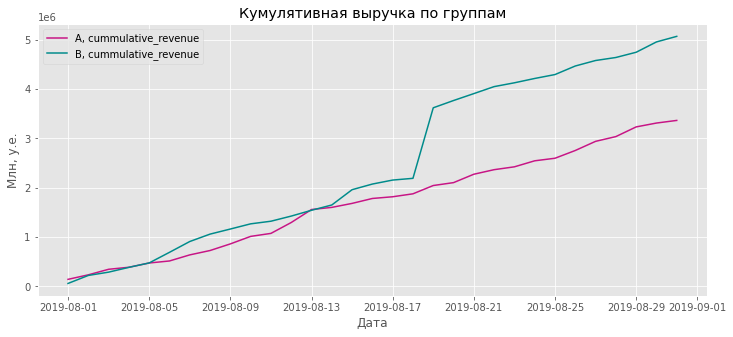

In [11]:
plt.figure(figsize=(12,5))
plt.style.use('ggplot')

plt.plot(ud['date'], ud['rev_a_cummy'], label='A, cummulative_revenue', color='MediumVioletRed')
plt.plot(ud['date'], ud['rev_b_cummy'], label='B, cummulative_revenue', color='DarkCyan')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Млн, у.е.')
plt.legend();

In [12]:
ud.tail(2)

,date,ord_a_qt,rev_a_daily,ord_b_qt,rev_b_daily,ord_a_qt_cummy,rev_a_cummy,avg_check_a,ord_b_qt_cummy,rev_b_cummy,avg_check_b,vis_a_qt,vis_b_qt,vis_a_qt_cummy,vis_b_qt_cummy,ord_by_vis_a,ord_by_vis_b
29,2019-08-30,9,78180,21,209223,460,3311413,7198.72,531,4955833,9333.02,490,490,18037,18198,39.21,34.27
30,2019-08-31,8,53243,17,113139,468,3364656,7189.44,548,5068972,9249.95,699,718,18736,18916,40.03,34.52


> ○ линия группы B чуть выше линии группы А. Вместе с тем начиная с 19 августа группа B существенно обгоняет группу А по показателю кумулятивной выручки
<br> ○ это может быть связано с тем, что в дату 19/08 случилась крупная выручка по группе B, что и подняло линию группы выше на весь оставшийся период. **Проверим это в графике выручки по дням + посмотрев срез датафрейма по датам:**

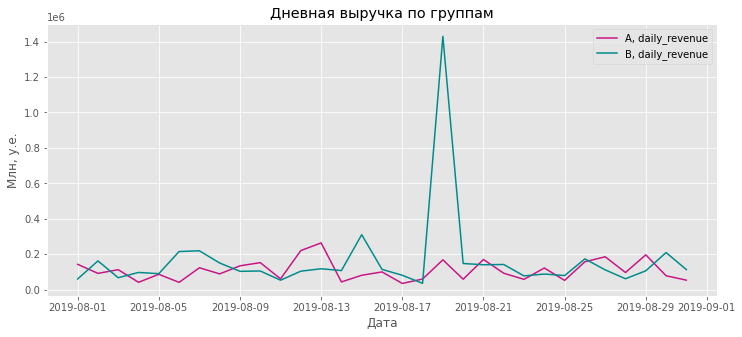

In [13]:
# строим графики выручки по дням
plt.figure(figsize=(12,5))
plt.plot(ud['date'], ud['rev_a_daily'], label='A, daily_revenue', color='MediumVioletRed')
plt.plot(ud['date'], ud['rev_b_daily'], label='B, daily_revenue', color='DarkCyan')
plt.title('Дневная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Млн, у.е.')
plt.legend();

In [14]:
# посмотрим выручку за день пика, а также за день до и после него
display(ud[['date', 'rev_a_daily', 'rev_b_daily']]
        .query('date >= "2019-08-18" and date <= "2019-08-20"')
        .style.background_gradient(cmap='terrain_r', axis=0))

,date,rev_a_daily,rev_b_daily
17,2019-08-18 00:00:00,59581,35323
18,2019-08-19 00:00:00,168193,1429920
19,2019-08-20 00:00:00,58679,147274


>**Итого знаем, что графики кумулятивной выручки искажены некой крупной покупкой в дату 19 августа. Теперь посмотрим, как будет выглядеть тот же график, но без выбросов:**

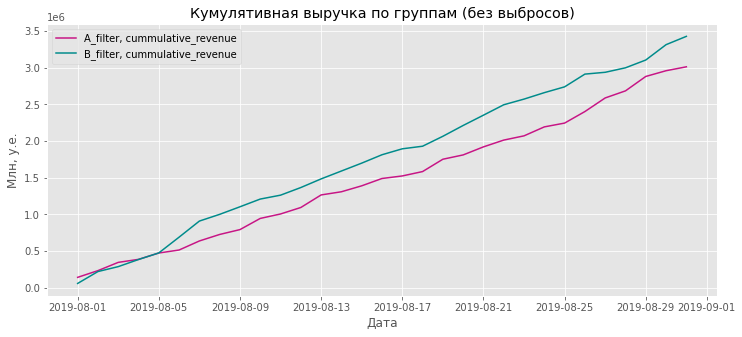

In [15]:
plt.figure(figsize=(12,5))

plt.plot(ud_f['date'], ud_f['rev_a_cummy'], label='A_filter, cummulative_revenue', color='MediumVioletRed')
plt.plot(ud_f['date'], ud_f['rev_b_cummy'], label='B_filter, cummulative_revenue', color='DarkCyan')
plt.title('Кумулятивная выручка по группам (без выбросов)')
plt.xlabel('Дата')
plt.ylabel('Млн, у.е.')
plt.legend();

> **Теперь можем сделать адекватный вывод, тк убрали выбросы из данных: 
<br>кумулятивная выручка группы B стабильно выше аналогичного показателя группы А в период тестирования**

### Анализ показателя: кумулятивный средний чек

> ○ построим сразу 2 графика: по данным с выбросами и без них

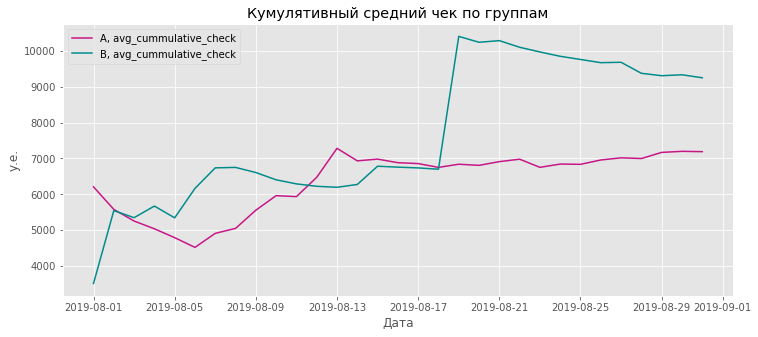

In [16]:
# данные без фильтра
plt.figure(figsize=(12,5))
plt.plot(ud['date'], ud['avg_check_a'], label='A, avg_cummulative_check', color='MediumVioletRed')
plt.plot(ud['date'], ud['avg_check_b'], label='B, avg_cummulative_check', color='DarkCyan')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('у.е.')
plt.legend();

> ○ видим аналогичный (предыдущему графику) пик в дату 19/08 
<br> ○ пик логичен, тк кумулятивный средний чек рассчитывается из кумулятивной выручки
<br>**Посмотрим, как будет выглядеть график на данных без выбросов:**

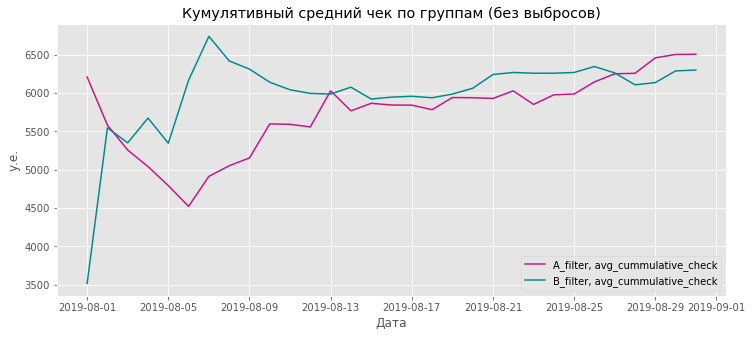

In [17]:
# данные отфльтрованы
plt.figure(figsize=(12,5))
plt.plot(ud_f['date'], ud_f['avg_check_a'], label='A_filter, avg_cummulative_check', color='MediumVioletRed')
plt.plot(ud_f['date'], ud_f['avg_check_b'], label='B_filter, avg_cummulative_check', color='DarkCyan')
plt.title('Кумулятивный средний чек по группам (без выбросов)')
plt.xlabel('Дата')
plt.ylabel('у.е.')
plt.legend();

> **По данным без выбросов видим:
<br> ○ данные сильно отличались в первую треть эксперимента, но далее +- стабилизировались 
<br> ○ по видимости в группе А ранее были недорогие заказы, средний чек с ходом эксперимента имеет тренд на рост
<br> ○ в группе В ситуация иная - в начале эксперимента значения были минимальными (видимо, были недорогие заказы), далее рост почти в 2 раза - после чего стабильные значения в коридоре 6-6200
<br> ○ также на отфильтрованных данных стал явно виден еще 1 пик в дату 7/08 по группе В - вероятно в ту дату "приплюсовались" дорогие и малочисленные заказы 
<br> ○ можно сказать, что кумулятивный средний чек группы В в основном выше, чем в группе А. Вместе с тем к концу теста группа А обогнала группу В**

### Анализ: относительное изменение кумулятивного среднего чека группы В к группе А

> ○ построим сразу 2 графика: по данным с выбросами и без них

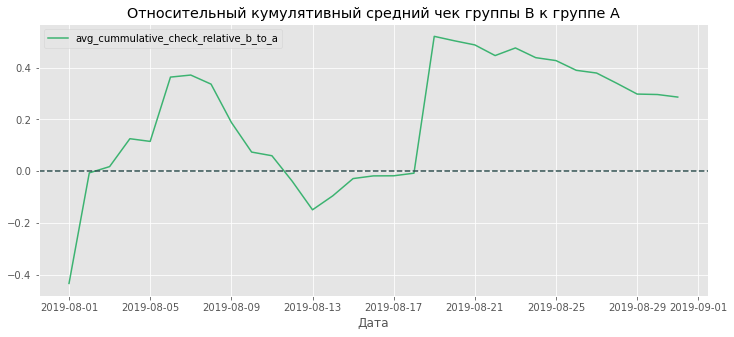

In [18]:
# данные без фильтра
plt.figure(figsize=(12,5))
(plt.plot(ud['date'], (ud['avg_check_b'] / ud['avg_check_a'] -1), 
          label='avg_cummulative_check_relative_b_to_a', color='MediumSeaGreen'))
plt.axhline(y=0, color='DarkSlateGrey', linestyle='--')
plt.title('Относительный кумулятивный средний чек группы В к группе А')
plt.xlabel('Дата')
plt.legend();

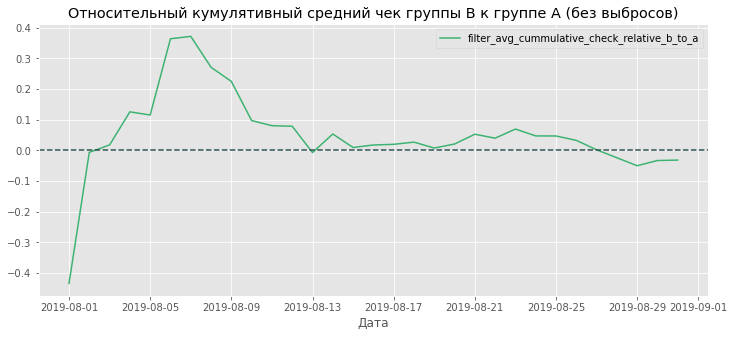

In [19]:
#данные отфильтрованы
plt.figure(figsize=(12,5))
(plt.plot(ud_f['date'], (ud_f['avg_check_b'] / ud_f['avg_check_a'] -1), 
          label='filter_avg_cummulative_check_relative_b_to_a', color='MediumSeaGreen'))
plt.axhline(y=0, color='DarkSlateGrey', linestyle='--')
plt.title('Относительный кумулятивный средний чек группы В к группе А (без выбросов)')
plt.xlabel('Дата')
plt.legend();

> **Сравнение графиков дало понимание ряда вещей:
<br> ○ пик в дату 19/08 (есть только в графике без фильтра) - обоснован выбросом
<br> ○ пик в даты 06-07/08 обоснован более дорогими / малочисленными заказами группы В, совершенными в эти даты
<br> ○ в целом - линия, в основном находится над контрольной линией (кроме начала периода и его конца). Тем не менее, к концу эксперимента показатель группы В стал ниже показателя группы А**

### Анализ: кумулятивное среднее кол-во заказов на посетителя по группам

> ○ строим график

In [20]:
# добавляем доп столбцы с конверсией
ud['conversion_a'] = ud['ord_a_qt_cummy'] / ud['vis_a_qt_cummy'] 
ud['conversion_b'] = ud['ord_b_qt_cummy'] / ud['vis_b_qt_cummy'] 

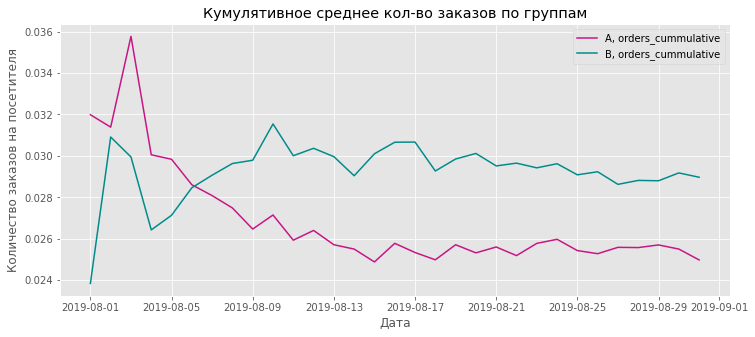

In [21]:
plt.figure(figsize=(12,5))
plt.plot(ud['date'], ud['conversion_a'], label='A, orders_cummulative', color='MediumVioletRed')
plt.plot(ud['date'], ud['conversion_b'], label='B, orders_cummulative', color='DarkCyan')
plt.title('Кумулятивное среднее кол-во заказов по группам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов на посетителя')
plt.legend();

> **Что мы видим:
<br> ○ кумулятивное среднее кол-во заказов на посетителя по группе А изначально было выше группы В, но в дату 6/08 все изиенилось: группа В ведет весь оставшийся период эксперимента
<br> ○ группа А имеет тренд на снижение; группа В сильно поднялась с начала эксперимента, вместе с тем есть также небольшой тренд на снижение к концу эксперимента. В целом видим, что группа В стабильно выше по уровню конверсии, нежели группа А**

### Анализ: относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A

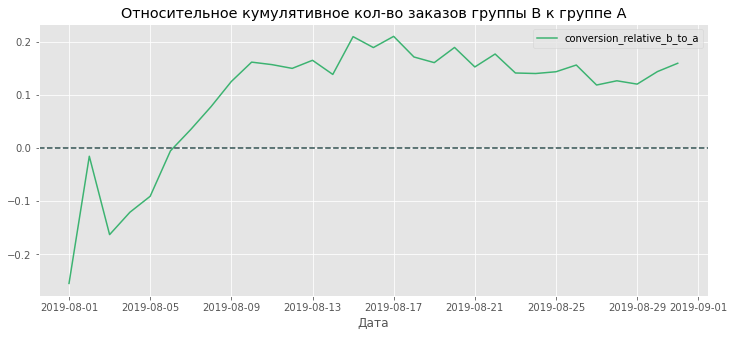

In [22]:
plt.figure(figsize=(12,5))
(plt.plot(ud['date'], (ud['conversion_b'] / ud['conversion_a'] -1), 
          label='conversion_relative_b_to_a', color='MediumSeaGreen'))
plt.axhline(y=0, color='DarkSlateGrey', linestyle='--')
plt.title('Относительное кумулятивное кол-во заказов группы В к группе А')
plt.xlabel('Дата')
plt.legend();

> **○ по данному графику можем сказать, что кумулятивная конверсия группы В уверенно выше аналогичного показателя группы А с даты 6/08**

### Анализ: количество заказов на пользователя

#### (график)

> ○ построим 3 маленьких датафрейма, сгруппировав данные по юзеру, чтобы получить кол-во уникальных заказов
<br> ○ зададим переменные x_values для простановки номеров
<br> ○ построим 3 графика по каждому датасету на одном полотне

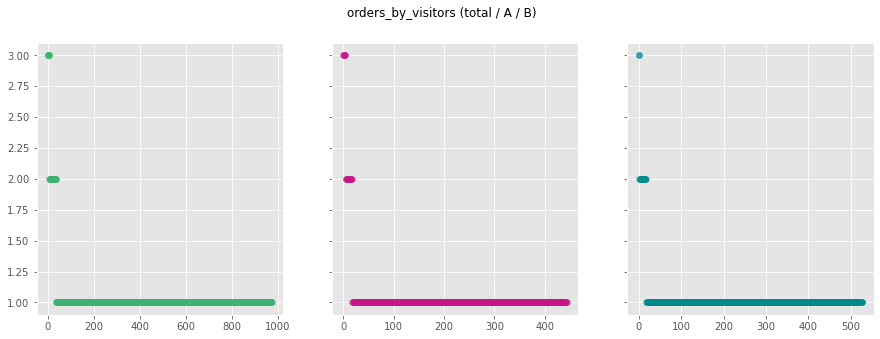

In [23]:
# создаем датасеты
ord_by_vis_a = (orders.query('group == "A"')
               .groupby('visitorId', as_index=False)
               .agg({'transactionId': pd.Series.nunique})
               .rename(columns={'transactionId': 'qt_a'})
               .sort_values(by='qt_a', ascending=False))

ord_by_vis_b = (orders.query('group == "B"')
               .groupby('visitorId', as_index=False)
               .agg({'transactionId': pd.Series.nunique})
               .rename(columns={'transactionId': 'qt_b'})
               .sort_values(by='qt_b', ascending=False))

orders_total = (orders.groupby('visitorId', as_index=False)
                .agg({'transactionId': pd.Series.nunique})
                .rename(columns={'transactionId': 'qt_all'})
                .sort_values(by='qt_all', ascending=False))

# объявляем переменные с номерами наблюдений для каждого фрейма
x_values_a = pd.Series(range(0, len(ord_by_vis_a)))
x_values_b = pd.Series(range(0, len(ord_by_vis_b)))
x_values_total = pd.Series(range(0, len(orders_total)))

# строим графики по каждому фрейму
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig.suptitle('orders_by_visitors (total / A / B)')
axs[0].scatter(x_values_total, orders_total['qt_all'], color='MediumSeaGreen', alpha=0.5);
axs[1].scatter(x_values_a, ord_by_vis_a['qt_a'], color='MediumVioletRed', alpha=0.5);
axs[2].scatter(x_values_b, ord_by_vis_b['qt_b'], color='DarkCyan', alpha=0.5);

> **Итого видим, что выбросов по количеству заказов - нет. Фильтровать данные не нужно, 2-3 заказа на клиента считаем нормальными значениями**

<br> *примечание для ревьюера: честно сказать, именно это полотно из 3 графиков показало мне, что есть юзеры, присутствующие в обеих группах (максимум графика тотал был выше максимумов по графикам групп А / В). Этих юзеров я исключила на шаге 1, в предобработке данных. Если бы я этого не сделала - то на графиках этого шага были бы неадекватные значения (типа 7). Их бы я и посчитала выбросами*

#### (перцентиль)

In [24]:
np.percentile(orders_total['qt_all'], [95,99])

array([1., 2.])

>**Уже с графика видели, что не будет высоких значений по кол-ву заказов на юзера. 99% клиентов имеют до 2 заказов включительно. Ничего не отсекаем**

### Анализ: стоимость заказов

#### (график)

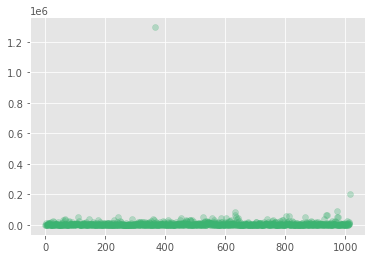

In [25]:
# сделали список с номерами экспериментов по кол-ву
x_values_rev = pd.Series(range(0, orders['transactionId'].nunique()))

# создаем график:
plt.scatter(x_values_rev, orders['revenue'], color='MediumSeaGreen', alpha=0.3);

> **Выбросы по суммам есть - видится, что их немного. Найдем перцентиль, чтобы понять, с какого значения начинается выброс**

#### (перцентиль)

In [26]:
np.percentile(orders['revenue'], [95,99])

array([26785., 53904.])

> ○ **99% заказов имеют сумму до 53904 (1% = ~10 человек), значение 53904 и примем за максимально возможное. Что выше него - будем считать выбросом.**
<br> ○ также отмечу, что это значение и было установлено в кач-ве параметра revenue_max в функции (см пункт 3.1.1)
<br> ○ посмотрим справочно - как изменится график, если удалить 10 покупок, подходящих под выброс:

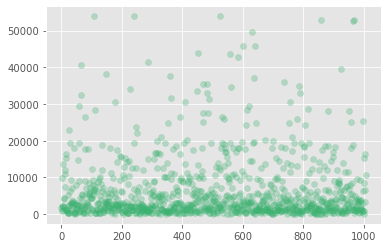

In [27]:
orders_filtered = orders.query('revenue <= 53904')
x_values_rev = pd.Series(range(0, orders_filtered['transactionId'].nunique()))
plt.scatter(x_values_rev, orders_filtered['revenue'], color='MediumSeaGreen', alpha=0.3);

> **Теперь данные выглядят нормально - нет пограничных значений, точки разбросаны равномерно. Перейдем к проверкам стат.значимости**

## Статитическая значимость различий между группами

### Статистическая значимость: среднее количество заказов

> ○ для расчета нам понадобятся уже созданные переменные с кол-вом заказов на посетителя + общий датасет с данными (по дням/кумулятивными и тд)
<br> ○ создаем переменные, в которых юзерам будет соответствовать кол-во заказов (а кто ничего не заказал - будет иметь 0 в поле)
<br> ○ проверим выборки критерием Манна-Уитни и сравним полученное pvalue с уровнем статистической значимости, чтобы понять, отличаются ли группы друг от друга по показателю кол-ва заказов на посетителя
<br> ○ проверим относительное различие среднего кол-ва заказов группы В к аналогичному показателю группы А

<div class="alert alert-block alert-info">
Сформулируем гипотезы:
    <br>H0 (нулевая гипотеза) - между группами нет статистически значимых различий в количестве заказов на посетителя
    <br>H1 (альтеративная гипотеза) - между группами есть статистически значимые различия в количестве заказов на посетителя

In [28]:
# A group, список клиентов с кол-вом заказов
sam_a = (pd
         .concat([ord_by_vis_a['qt_a'],
                  pd.Series(0,index=np.arange(ud['vis_a_qt'].sum() - len(ord_by_vis_a['qt_a'])), name='qt')], 
                 axis=0))

# B group, список клиентов с кол-вом заказов
sam_b = (pd
         .concat([ord_by_vis_b['qt_b'],
                  pd.Series(0,index=np.arange(ud['vis_b_qt'].sum() - len(ord_by_vis_b['qt_b'])), name='qt')], 
                 axis=0))

# рассчитываем критерий Манна-Уитни
# рассчитываем относительное различие среднего кол-ва заказов группы В к группе А
results_avg_qt = stats.mannwhitneyu(sam_a, sam_b)
relative_avg_qt = (sam_b.mean() / sam_a.mean() - 1)

print("p_value (среднее кол-во заказов) = {0:.3f}".format(results_avg_qt.pvalue))
print("относительный прирост среднего числа заказов группы B = {0:.3f}".format(relative_avg_qt))
print()
alpha = .05
if (results_avg_qt.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть статистически значимые различия в количестве заказов на посетителя")
else:
    print("Не получилось отвергнуть нулевую гипотезу: между группами нет статистически значимых различий в количестве заказов на посетителя")

p_value (среднее кол-во заказов) = 0.006
относительный прирост среднего числа заказов группы B = 0.160

Отвергаем нулевую гипотезу: между группами есть статистически значимые различия в количестве заказов на посетителя


> **Тест показал, что есть статистические различия в кол-ве заказов, при этом в относительном различии среднего кол-ва заказов группа B показала себя на 16% лучше группы А.**

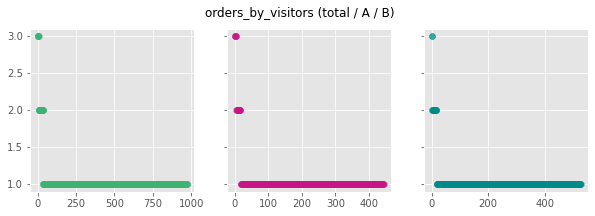

In [29]:
# строим графики по каждому фрейму
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=True)
fig.suptitle('orders_by_visitors (total / A / B)')
axs[0].scatter(x_values_total, orders_total['qt_all'], color='MediumSeaGreen', alpha=0.5);
axs[1].scatter(x_values_a, ord_by_vis_a['qt_a'], color='MediumVioletRed', alpha=0.5);
axs[2].scatter(x_values_b, ord_by_vis_b['qt_b'], color='DarkCyan', alpha=0.5);

In [30]:
np.percentile(orders_total['qt_all'], [95,99])

array([1., 2.])

In [31]:
orders_total.sort_values(by='qt_all', ascending=False).head(5)

,visitorId,qt_all
908,3967698036,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3


### Статистическая значимость: средний чек заказа ("сырые" данные)

> ○ для лаконичности кода объявим переменные со срезами сета orders по группам
<br> ○ проверим выборки критерием Манна-Уитни и сравним полученное pvalue с уровнем статистической значимости, чтобы понять, отличаются ли группы друг от друга по показателю среднего чека
<br> ○ проверим относительное различие среднего чека группы В к аналогичному показателю группы А

<div class="alert alert-block alert-info">
Сформулируем гипотезы:
    <br>H0 (нулевая гипотеза) - между группами нет статистически значимых различий в среднем чеке заказа
    <br>H1 (альтеративная гипотеза) - между группами есть статистически значимые различия в среднем чеке заказа

In [32]:
o_a = orders.query('group == "A"')
o_b = orders.query('group == "B"')

results_avg_check = stats.mannwhitneyu(o_a['revenue'], o_b['revenue'])
relative_avg_check = (o_b['revenue'].mean() / o_a['revenue'].mean() - 1)

print("p_value (средний чек заказа, 'сырые' данные) = {0:.3f}".format(results_avg_check.pvalue))
print("относительный прирост среднего чека заказа группы B = {0:.3f}".format(relative_avg_check))
print()
alpha = .05
if (results_avg_check.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть статистически значимые различия")
else:
    print("Не получилось отвергнуть нулевую гипотезу: между группами нет статистически значимых различий")

p_value (средний чек заказа, 'сырые' данные) = 0.415
относительный прирост среднего чека заказа группы B = 0.287

Не получилось отвергнуть нулевую гипотезу: между группами нет статистически значимых различий


**p_value значительно больше 0.05. Соответственно, у нас нет причин отвергать нулевую гипотезу и считать, что существуют статистически значимые различия в среднем чеке групп - несмотря на наблюдаемое различие в средних чеках (средний чек заказа в группе В выше аналогичного показателя группы А на 28.7%)**

### Статистическая значимость: средний чек заказа ("чистые" данные)

<div class="alert alert-block alert-info">
Сформулируем гипотезы:
    <br>H0 (нулевая гипотеза) - между группами нет статистически значимых различий в среднем чеке заказа
    <br>H1 (альтеративная гипотеза) - между группами есть статистически значимые различия в среднем чеке заказа

> ○ сделаем действия, аналогичные предыдущему пункту - с учетом корректировки датасетов с данными заказов
<br> ○ возьмем в расчет сет orders_filtered (в нем уже отсечены значения выше 53904 (см пункт 3.8.2))

In [33]:
o_a_clear = orders_filtered.query('group == "A"')
o_b_clear = orders_filtered.query('group == "B"')

results_avg_check_clear = stats.mannwhitneyu(o_a_clear['revenue'], o_b_clear['revenue'])
relative_avg_check_clear = ((o_b_clear['revenue'].mean() / o_a_clear['revenue'].mean()) - 1)

print("p_value (средний чек заказа, 'чистые' данные) = {0:.3f}".format(results_avg_check_clear.pvalue))
print("относительный прирост среднего чека заказа группы B = {0:.3f}".format(relative_avg_check_clear))
print()
alpha = .05
if (results_avg_check_clear.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть статистически значимые различия")
else:
    print("Не получилось отвергнуть нулевую гипотезу: между группами нет статистически значимых различий")

p_value (средний чек заказа, 'чистые' данные) = 0.450
относительный прирост среднего чека заказа группы B = -0.032

Не получилось отвергнуть нулевую гипотезу: между группами нет статистически значимых различий


**Видим, как изменился относительный средний чек группы В к группе А - после исключения выбросов он стал даже ниже на 3% (выбросы оказывали существенное влияние). Вместе с этим уровень p_value все также превышает 0.05 - значит нет причин думать, что между выборками есть статистически значимые различия в показателе среднего чека заказа**

## Выводы

>**Итого по тесту имеем:**
<br> ○ по кумулятивной выручке группа В лидирует (график пункта 3.2)
<br> ○ кумулятивный средний чек группы В был выше в начале эксперимента, сейчас группа А перегнала группу В по этому показателю (пункт 3.3), то же самое видим в пункте 3.4 в относительном графике
<br> ○ по графику кумулятивной конверсии лидирует группа В
<br> ○ по стат значимости: группы различаются по показателю среднего кол-ва заказов, при этом группа В выигрывает на 16% в части относительного прироста кол-ва числа заказов
<br> ○ по показателю среднего чека нет статистических различий между выборками. Средний чек группы В лидирует только с включенными выбросами, без выбросов относительный проигрыш группы В - около 3%
<br>

<br>**Тест продолжался достаточное кол-во времени, группа В имеет стат.значимые отличия по среднему кол-ву заказов + показывает относительный прирост кол-ва заказов / также по всем кумулятивным графикам видим однозначное лидерство группы В. Тест следует завершить, признав победу за группой В.**